<a href="https://colab.research.google.com/github/vifirsanova/IT_seminar_project/blob/main/GLUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets transformers

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML
import numpy as np

In [ ]:
import transformers

print(transformers.__version__)

4.12.5


In [ ]:
# авторизация HuggingFace
 
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-crendential store but this isn't the helper defined on your machine.
You will have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal to set it as the default

git config --global credential.helper store


In [ ]:
!apt install git-lfs

Базовые задачи GLUE для английского языка

- [CoLA](https://nyu-mll.github.io/CoLA/) (Corpus of Linguistic Acceptability) Грамматическая корректность высказывания (бинарная классификация)
- [MNLI](https://arxiv.org/abs/1704.05426) (Multi-Genre Natural Language Inference) Установить, заданное предложение соответсвует, противоречит или вообще не связано с гипотезой. 
- [MRPC](https://www.microsoft.com/en-us/download/details.aspx?id=52398) (Microsoft Research Paraphrase Corpus) Установить, является ли предложение А перефразированием предложения B.
- [QNLI](https://rajpurkar.github.io/SQuAD-explorer/) (Question-answering Natural Language Inference) Установить, является ли предложение ответом на заданный вопрос.
- [WNLI](https://cs.nyu.edu/faculty/davise/papers/WinogradSchemas/WS.html) (Winograd Natural Language Inference) Установить связь неоднозначного местоимения в двух предложениях.

In [ ]:
task = "wnli"
model_checkpoint = "bert-base-multilingual-cased"
batch_size = 16

Датасеты


In [ ]:
from datasets import load_dataset, load_metric

Для обучения модели следует использовать более "широкую" модель


In [ ]:
actual_task = "wnli" 
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset["train"][0]

{'idx': 0,
 'label': 1,
 'sentence1': 'I stuck a pin through a carrot. When I pulled the pin out, it had a hole.',
 'sentence2': 'The carrot had a hole.'}

Токенизация

In [ ]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [ ]:
tokenizer("Образец токенизации")

{'input_ids': [101, 18890, 34556, 16688, 84964, 15065, 33917, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

sentence1_key, sentence2_key = task_to_keys[task]

encoded_dataset = dataset.map(preprocess_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-72977d9baf9046df.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-a206d399168b9d31.arrow


Тонкая настройка модели

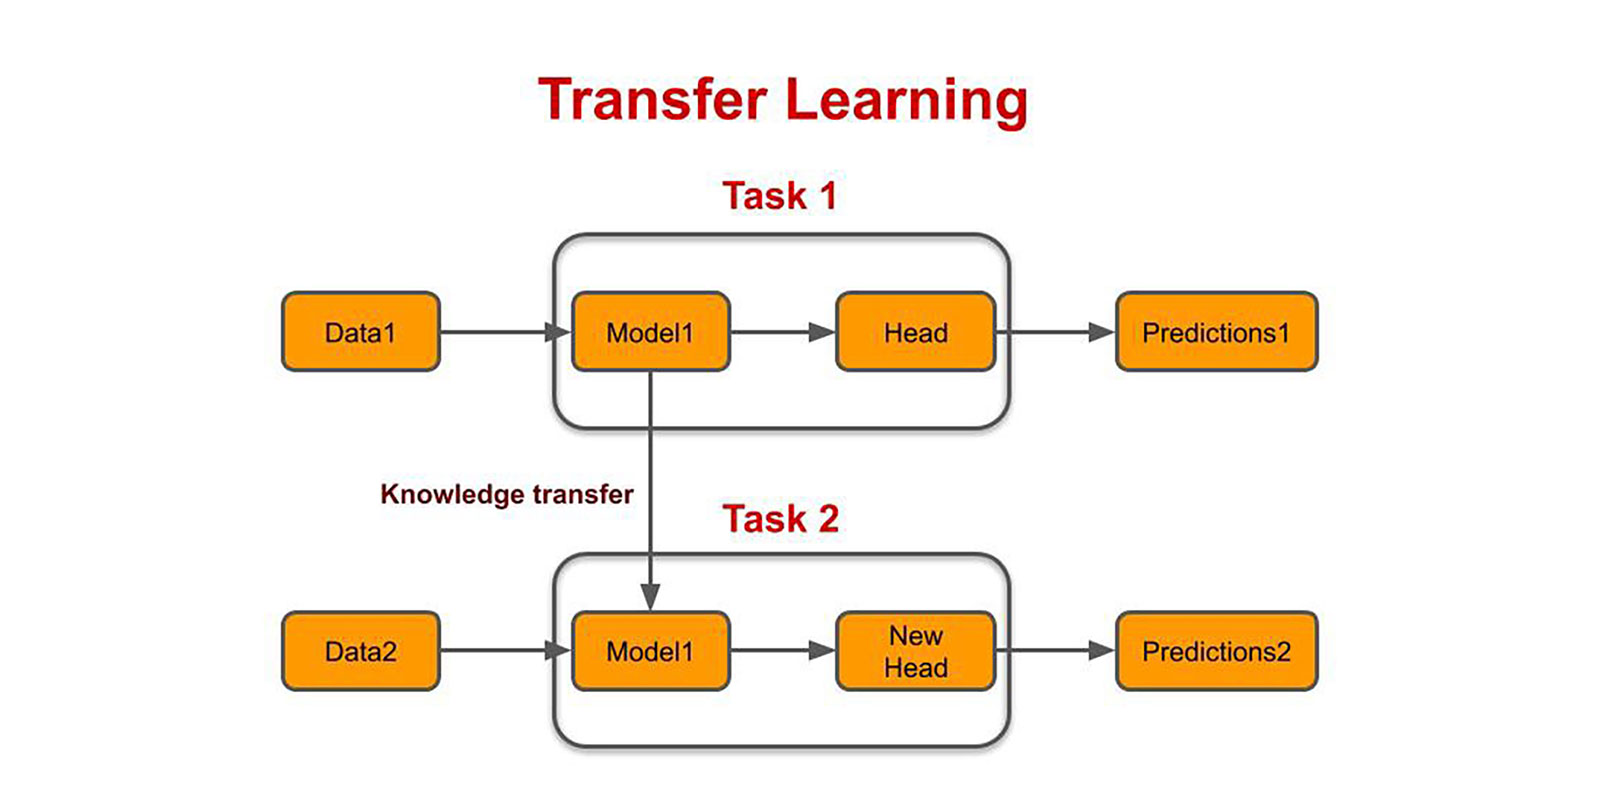

In [ ]:
# загрузка модулей для обучения

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

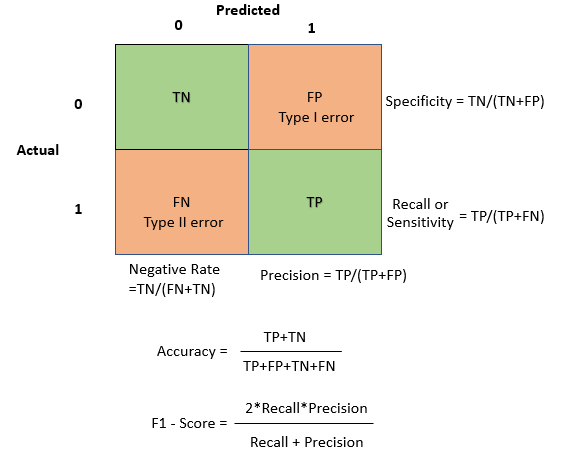

In [ ]:
# Передаем все в Trainer

validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/missvector/bert-base-multilingual-cased-finetuned-wnli into local empty directory.


In [ ]:
trainer.train()

In [24]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx.
***** Running Evaluation *****
  Num examples = 71
  Batch size = 16


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.685100,0.563380
2,No log,0.685100,0.563380
3,No log,0.685100,0.563380
3,No log,0.685100,0.563380


{'eval_accuracy': 0.5633802816901409, 'eval_loss': 0.6850997805595398}